<a href="https://colab.research.google.com/github/rohailkhan/deep_learning/blob/master/0602_Time_Invariant_Face_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:


# بسم الله الرحمن الرحيم
اللهم صل على محمد وعلى آل محمد كما صليت على إبراهيم وعلى آل إبراهيم إنك حميد مجيد، اللهم بارك على محمد وعلى آل محمد كما باركت على إبراهيم وعلى آل إبراهيم إنك حميد مجيد




In [3]:
from keras.models import Sequential
"""Import from keras_preprocessing not from keras.preprocessing, 
because Keras may or maynot contain the features discussed here 
depending upon when you read this article, until the keras_
preprocessed library is updated in Keras use the github version."""
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
import pandas as pd
import numpy as np
import os ,PIL
import matplotlib.pyplot as plt


Using TensorFlow backend.


In [0]:
# Put all files into a single dataframe
list_dir = [i for i in os.listdir('/content/drive/My Drive/Aging model/datafiles')]
final_df = pd.DataFrame(columns=['ID','Facial Index','Mandibular Index','Intercantal Index','Orbital Width Index','Eye Fissure Index','Vermilion Height Index','Mouth Face Width Index','AGE'])
interim_df = pd.DataFrame(columns=['ID','Facial Index','Mandibular Index','Intercantal Index','Orbital Width Index','Eye Fissure Index','Vermilion Height Index','Mouth Face Width Index','AGE'])
age_list=list()
for d in list_dir:
    interim_df.at[0,  ['Facial Index','Mandibular Index','Intercantal Index','Orbital Width Index','Eye Fissure Index','Vermilion Height Index','Mouth Face Width Index']] = pd.read_csv('/content/drive/My Drive/Aging model/datafiles/'+d, sep=" ", header=None).values[0][:7]
    interim_df['AGE'] = int(d[4:].replace('.txt','').replace('a','').replace('b',''))
    interim_df['ID'] = int(d[:3])
    final_df = pd.concat([final_df,interim_df])
    
# sort values by age of same person
final_df = final_df.sort_values(['ID','AGE'],ascending=True)

In [0]:
final_df.to_csv('/content/drive/My Drive/Aging model/new/final_df.csv',index=False)

## Start

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
final_df=pd.read_csv('/content/drive/My Drive/Aging model/new/final_df.csv')

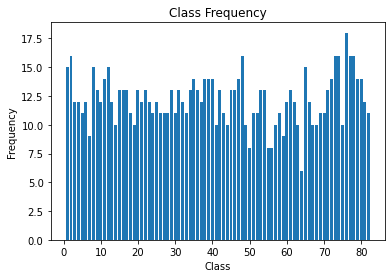

In [5]:
classes=final_df[['ID']].values
unique, counts = np.unique(classes, return_counts=True)
plt.bar(unique,counts)
plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

# One hot encoding

In [0]:
# use pd.concat to join the new columns with your original dataframe
df = pd.concat([final_df['ID'],pd.get_dummies(final_df['ID'], prefix='person')],axis=1)

In [0]:
# addng file names
image_names=[]
for i in os.listdir('/content/drive/My Drive/Aging model/fgbw'):
  image_names.append(i)

In [0]:
df['file_name']=image_names

In [11]:
df.tail(2)

,ID,person_1,person_2,person_3,person_4,person_5,person_6,person_7,person_8,person_9,person_10,person_11,person_12,person_13,person_14,person_15,person_16,person_17,person_18,person_19,person_20,person_21,person_22,person_23,person_24,person_25,person_26,person_27,person_28,person_29,person_30,person_31,person_32,person_33,person_34,person_35,person_36,person_37,person_38,person_39,...,person_44,person_45,person_46,person_47,person_48,person_49,person_50,person_51,person_52,person_53,person_54,person_55,person_56,person_57,person_58,person_59,person_60,person_61,person_62,person_63,person_64,person_65,person_66,person_67,person_68,person_69,person_70,person_71,person_72,person_73,person_74,person_75,person_76,person_77,person_78,person_79,person_80,person_81,person_82,file_name
1000,82,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,001A02.JPG
1001,82,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,001A18.JPG


In [0]:
df.to_csv('/content/drive/My Drive/Aging model/new/df.csv',index=False)

# Start reading CSV

In [0]:
final_df=pd.read_csv('/content/drive/My Drive/Aging model/new/df.csv')


In [0]:
final_df=df

In [13]:
final_df.tail(2)

,ID,person_1,person_2,person_3,person_4,person_5,person_6,person_7,person_8,person_9,person_10,person_11,person_12,person_13,person_14,person_15,person_16,person_17,person_18,person_19,person_20,person_21,person_22,person_23,person_24,person_25,person_26,person_27,person_28,person_29,person_30,person_31,person_32,person_33,person_34,person_35,person_36,person_37,person_38,person_39,...,person_44,person_45,person_46,person_47,person_48,person_49,person_50,person_51,person_52,person_53,person_54,person_55,person_56,person_57,person_58,person_59,person_60,person_61,person_62,person_63,person_64,person_65,person_66,person_67,person_68,person_69,person_70,person_71,person_72,person_73,person_74,person_75,person_76,person_77,person_78,person_79,person_80,person_81,person_82,file_name
1000,82,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,001A02.JPG
1001,82,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,001A18.JPG


# Splitting data in training and validation(test) sets

In [0]:
train_size = len(final_df['ID'].unique()) * .8
train = pd.DataFrame()
valid = pd.DataFrame()
for n,i in enumerate(final_df['ID'].unique()):
    if n< train_size:
        train = pd.concat([train, final_df[final_df['ID']==i]])
    else:
        valid = pd.concat([valid, final_df[final_df['ID']==i]])

In [15]:
print('Training Set Has: ' + str(len(train.groupby('ID').count())) + ' people')
print('Validation (Test) Set Has: ' + str(len(valid.groupby('ID').count())) + ' people')

Training Set Has: 66 people
Validation (Test) Set Has: 16 people


# Preparing Test data

In [16]:
np.unique(train.ID.values)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66])

In [17]:
test_ids= [ 34,35, 36, 37, 38, 39, 40, 41] 
# selecting rows based on condition 
test= train[train['ID'].isin(test_ids)] 
test.head(3)

,ID,person_1,person_2,person_3,person_4,person_5,person_6,person_7,person_8,person_9,person_10,person_11,person_12,person_13,person_14,person_15,person_16,person_17,person_18,person_19,person_20,person_21,person_22,person_23,person_24,person_25,person_26,person_27,person_28,person_29,person_30,person_31,person_32,person_33,person_34,person_35,person_36,person_37,person_38,person_39,...,person_44,person_45,person_46,person_47,person_48,person_49,person_50,person_51,person_52,person_53,person_54,person_55,person_56,person_57,person_58,person_59,person_60,person_61,person_62,person_63,person_64,person_65,person_66,person_67,person_68,person_69,person_70,person_71,person_72,person_73,person_74,person_75,person_76,person_77,person_78,person_79,person_80,person_81,person_82,file_name
404,34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,034A25.JPG
405,34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,034A21.JPG
406,34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,034A16.JPG


In [18]:
train.columns

Index(['ID', 'person_1', 'person_2', 'person_3', 'person_4', 'person_5',
       'person_6', 'person_7', 'person_8', 'person_9', 'person_10',
       'person_11', 'person_12', 'person_13', 'person_14', 'person_15',
       'person_16', 'person_17', 'person_18', 'person_19', 'person_20',
       'person_21', 'person_22', 'person_23', 'person_24', 'person_25',
       'person_26', 'person_27', 'person_28', 'person_29', 'person_30',
       'person_31', 'person_32', 'person_33', 'person_34', 'person_35',
       'person_36', 'person_37', 'person_38', 'person_39', 'person_40',
       'person_41', 'person_42', 'person_43', 'person_44', 'person_45',
       'person_46', 'person_47', 'person_48', 'person_49', 'person_50',
       'person_51', 'person_52', 'person_53', 'person_54', 'person_55',
       'person_56', 'person_57', 'person_58', 'person_59', 'person_60',
       'person_61', 'person_62', 'person_63', 'person_64', 'person_65',
       'person_66', 'person_67', 'person_68', 'person_69', 'person_

In [0]:
# removing 34,35, 36, 37, 38, 39, 40, 41 indices
train_ids=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11',
       '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '42', '43', '44', '45', '46', '47',
       '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59',
       '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71',
       '72', '73', '74', '75', '76', '77', '78', '79', '80', '81']

In [21]:
train= train[train['ID'].isin(train_ids)] 
train.head(3)

,ID,person_1,person_2,person_3,person_4,person_5,person_6,person_7,person_8,person_9,person_10,person_11,person_12,person_13,person_14,person_15,person_16,person_17,person_18,person_19,person_20,person_21,person_22,person_23,person_24,person_25,person_26,person_27,person_28,person_29,person_30,person_31,person_32,person_33,person_34,person_35,person_36,person_37,person_38,person_39,...,person_44,person_45,person_46,person_47,person_48,person_49,person_50,person_51,person_52,person_53,person_54,person_55,person_56,person_57,person_58,person_59,person_60,person_61,person_62,person_63,person_64,person_65,person_66,person_67,person_68,person_69,person_70,person_71,person_72,person_73,person_74,person_75,person_76,person_77,person_78,person_79,person_80,person_81,person_82,file_name
0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,002A03.JPG
1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,001A33.JPG
2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,001A28.JPG


In [27]:
print('Training    Set Has: ' + str(len(train.groupby('ID').count())) + ' people')
print('Validation  Set Has: ' + str(len(valid.groupby('ID').count())) + ' people')
print('.....Test   Set Has:  ' + str(len(test.groupby('ID').count())) + ' people')

Training    Set Has: 58 people
Validation  Set Has: 16 people
.....Test   Set Has:  8 people


# Target labels

In [28]:
test.columns

Index(['ID', 'person_1', 'person_2', 'person_3', 'person_4', 'person_5',
       'person_6', 'person_7', 'person_8', 'person_9', 'person_10',
       'person_11', 'person_12', 'person_13', 'person_14', 'person_15',
       'person_16', 'person_17', 'person_18', 'person_19', 'person_20',
       'person_21', 'person_22', 'person_23', 'person_24', 'person_25',
       'person_26', 'person_27', 'person_28', 'person_29', 'person_30',
       'person_31', 'person_32', 'person_33', 'person_34', 'person_35',
       'person_36', 'person_37', 'person_38', 'person_39', 'person_40',
       'person_41', 'person_42', 'person_43', 'person_44', 'person_45',
       'person_46', 'person_47', 'person_48', 'person_49', 'person_50',
       'person_51', 'person_52', 'person_53', 'person_54', 'person_55',
       'person_56', 'person_57', 'person_58', 'person_59', 'person_60',
       'person_61', 'person_62', 'person_63', 'person_64', 'person_65',
       'person_66', 'person_67', 'person_68', 'person_69', 'person_

In [0]:
# Only keeping the labels in the Target columns
target_columns=['person_1', 'person_2', 'person_3', 'person_4', 'person_5',
       'person_6', 'person_7', 'person_8', 'person_9', 'person_10',
       'person_11', 'person_12', 'person_13', 'person_14', 'person_15',
       'person_16', 'person_17', 'person_18', 'person_19', 'person_20',
       'person_21', 'person_22', 'person_23', 'person_24', 'person_25',
       'person_26', 'person_27', 'person_28', 'person_29', 'person_30',
       'person_31', 'person_32', 'person_33', 'person_34', 'person_35',
       'person_36', 'person_37', 'person_38', 'person_39', 'person_40',
       'person_41', 'person_42', 'person_43', 'person_44', 'person_45',
       'person_46', 'person_47', 'person_48', 'person_49', 'person_50',
       'person_51', 'person_52', 'person_53', 'person_54', 'person_55',
       'person_56', 'person_57', 'person_58', 'person_59', 'person_60',
       'person_61', 'person_62', 'person_63', 'person_64', 'person_65',
       'person_66', 'person_67', 'person_68', 'person_69', 'person_70',
       'person_71', 'person_72', 'person_73', 'person_74', 'person_75',
       'person_76', 'person_77', 'person_78', 'person_79', 'person_80',
       'person_81', 'person_82']

In [0]:
len(target_columns)

# Using the Best Model 6 in Notebook 0601

In [0]:
# adding regularization
from keras.regularizers import l2
from keras.layers.advanced_activations import LeakyReLU
act = LeakyReLU(alpha=0.1)

In [0]:
## Alhamdulillah...

model6 =Sequential()

model6.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
model6.add(act)
model6.add(MaxPooling2D((2, 2)))
model6.add(Dropout(0.2))


model6.add(Conv2D(64, (3, 3)))
model6.add(act)
model6.add(MaxPooling2D((2, 2)))
model6.add(Dropout(0.2))


model6.add(Conv2D(62, (3,3), kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model6.add(act)
model6.add(MaxPooling2D((2, 2)))
model6.add(Dropout(0.2))


model6.add(Conv2D(128, (3, 3)))
model6.add(act)
model6.add(MaxPooling2D((2, 2)))
model6.add(Dropout(0.2))


model6.add(Conv2D(128, (3, 3)))
model6.add(act)
model6.add(MaxPooling2D((2, 2)))
model6.add(Dropout(0.2))

model6.add(Flatten())
model6.add(Dropout(0.2))
model6.add(Dense(512))
model6.add(act)
model6.add(Dense(82, activation='sigmoid'))

model6.compile(loss='binary_crossentropy',
optimizer=optimizers.Adam(lr=1e-5),
metrics=['accuracy'])


# **Defining Train ,Validation and Test generator**

## First doing Face Augmentation only for the Train Data

In [0]:
## Defining Augmentation object using ImageDataGenerator
TRAIN_DATAGEN = ImageDataGenerator(
rescale=1./255,
rotation_range=40,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,)

In [35]:
train_generator=TRAIN_DATAGEN.flow_from_dataframe(
dataframe=train,
directory="/content/drive/My Drive/Aging model/fg",
x_col='file_name',
y_col=target_columns,
batch_size=32,
seed=42,
shuffle=True,class_mode='raw',
target_size=(150,150))

Found 686 validated image filenames.


In [36]:
valid_datagen = ImageDataGenerator(rescale=1./255)

valid_generator=valid_datagen.flow_from_dataframe(
dataframe=valid,
directory="/content/drive/My Drive/Aging model/fg",
x_col='file_name',
y_col=target_columns,
batch_size=32,
seed=42,
shuffle=True,class_mode='raw',
target_size=(150,150))

Found 212 validated image filenames.


In [37]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator=valid_datagen.flow_from_dataframe(
dataframe=test,
directory="/content/drive/My Drive/Aging model/fg",
x_col='file_name',
y_col=target_columns,
batch_size=32,
seed=42,
shuffle=True,class_mode='raw',
target_size=(150,150))

Found 104 validated image filenames.


# Training begins Experiment 1 (model 6)

In [38]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

history =model6.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=20
)

Epoch 1/20
21/21 [==============================] - 317s 15s/step - loss: 1.3238 - accuracy: 0.5181 - val_loss: 1.3174 - val_accuracy: 0.5772
Epoch 2/20
21/21 [==============================] - 21s 1s/step - loss: 1.3006 - accuracy: 0.6039 - val_loss: 1.3068 - val_accuracy: 0.6628
Epoch 3/20
21/21 [==============================] - 6s 299ms/step - loss: 1.2736 - accuracy: 0.6774 - val_loss: 1.2935 - val_accuracy: 0.7528
Epoch 4/20
21/21 [==============================] - 6s 300ms/step - loss: 1.2357 - accuracy: 0.7476 - val_loss: 1.2744 - val_accuracy: 0.8220
Epoch 5/20
21/21 [==============================] - 6s 289ms/step - loss: 1.1799 - accuracy: 0.8076 - val_loss: 1.2394 - val_accuracy: 0.8713
Epoch 6/20
21/21 [==============================] - 6s 295ms/step - loss: 1.1005 - accuracy: 0.8594 - val_loss: 1.1808 - val_accuracy: 0.9139
Epoch 7/20
21/21 [==============================] - 6s 292ms/step - loss: 0.9992 - accuracy: 0.9046 - val_loss: 1.1096 - val_accuracy: 0.9527
Epoch 8/

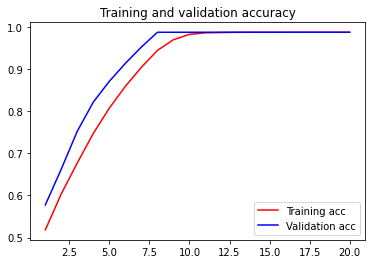

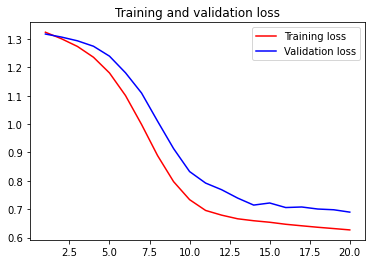

In [39]:
#MAY 30 am
### FINAL Alhamdulillah...use sigmoid with binary-entropy...
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Evaluating on un seen data

In [40]:
score=model6.evaluate_generator(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.7143713235855103
Test accuracy: 0.9878048300743103


#Using bigger size images in bw

In [0]:
## Alhamdulillah...

model6 =Sequential()

model6.add(Conv2D(32, (3, 3), input_shape=(300,300, 3)))
model6.add(act)
model6.add(MaxPooling2D((2, 2)))
model6.add(Dropout(0.2))


model6.add(Conv2D(64, (3, 3)))
model6.add(act)
model6.add(MaxPooling2D((2, 2)))
model6.add(Dropout(0.2))


model6.add(Conv2D(62, (3,3), kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model6.add(act)
model6.add(MaxPooling2D((2, 2)))
model6.add(Dropout(0.2))


model6.add(Conv2D(128, (3, 3)))
model6.add(act)
model6.add(MaxPooling2D((2, 2)))
model6.add(Dropout(0.2))


model6.add(Conv2D(128, (3, 3)))
model6.add(act)
model6.add(MaxPooling2D((2, 2)))
model6.add(Dropout(0.2))

model6.add(Flatten())
model6.add(Dropout(0.2))
model6.add(Dense(512))
model6.add(act)
model6.add(Dense(82, activation='sigmoid'))

model6.compile(loss='binary_crossentropy',
optimizer=optimizers.Adam(lr=1e-5),
metrics=['accuracy'])


In [0]:
## Defining Augmentation object using ImageDataGenerator
TRAIN_DATAGEN = ImageDataGenerator(
rescale=1./255,
rotation_range=40,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,)

In [48]:
train_generator=TRAIN_DATAGEN.flow_from_dataframe(
dataframe=train,
directory="/content/drive/My Drive/Aging model/fgbw",
x_col='file_name',
y_col=target_columns,
batch_size=32,
seed=42,
shuffle=True,class_mode='raw',
target_size=(300,300))

Found 686 validated image filenames.


In [49]:
valid_datagen = ImageDataGenerator(rescale=1./255)

valid_generator=valid_datagen.flow_from_dataframe(
dataframe=valid,
directory="/content/drive/My Drive/Aging model/fgbw",
x_col='file_name',
y_col=target_columns,
batch_size=32,
seed=42,
shuffle=True,class_mode='raw',
target_size=(300,300))

Found 212 validated image filenames.


In [50]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator=valid_datagen.flow_from_dataframe(
dataframe=test,
directory="/content/drive/My Drive/Aging model/fgbw",
x_col='file_name',
y_col=target_columns,
batch_size=32,
seed=42,
shuffle=True,class_mode='raw',
target_size=(300,300))

Found 104 validated image filenames.


# Training begins Experiment 2 (model 6) using bigger target size in bw images

In [51]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

history =model6.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=20
)

Epoch 1/20
21/21 [==============================] - 313s 15s/step - loss: 1.2833 - accuracy: 0.6440 - val_loss: 1.2965 - val_accuracy: 0.8435
Epoch 2/20
21/21 [==============================] - 30s 1s/step - loss: 1.1616 - accuracy: 0.8707 - val_loss: 1.2443 - val_accuracy: 0.9505
Epoch 3/20
21/21 [==============================] - 14s 653ms/step - loss: 0.9866 - accuracy: 0.9561 - val_loss: 1.1485 - val_accuracy: 0.9878
Epoch 4/20
21/21 [==============================] - 13s 623ms/step - loss: 0.8095 - accuracy: 0.9855 - val_loss: 1.0262 - val_accuracy: 0.9878
Epoch 5/20
21/21 [==============================] - 14s 648ms/step - loss: 0.7183 - accuracy: 0.9878 - val_loss: 0.9214 - val_accuracy: 0.9878
Epoch 6/20
21/21 [==============================] - 14s 647ms/step - loss: 0.6886 - accuracy: 0.9878 - val_loss: 0.8619 - val_accuracy: 0.9878
Epoch 7/20
21/21 [==============================] - 13s 640ms/step - loss: 0.6795 - accuracy: 0.9878 - val_loss: 0.8450 - val_accuracy: 0.9878
Epo

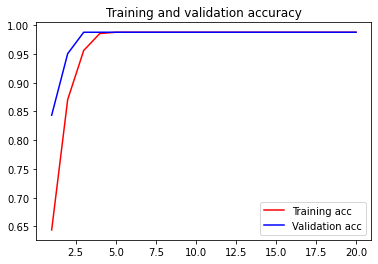

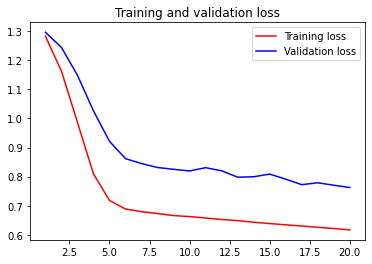

In [52]:
#MAY 30 am
### FINAL Alhamdulillah...use sigmoid with binary-entropy...
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [53]:
score=model6.evaluate_generator(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.8115292191505432
Test accuracy: 0.9878048300743103
